In [41]:
from bids import BIDSLayout
import pandas as pd
import numpy as np
import scipy
import json
import pyedflib
import re
import nibabel as nb
import os

In [42]:
# Load dataset
data_path = '/scratch/mcesped/Results/seegprep/hipp_run/bids/'
layout = BIDSLayout(data_path, validate=False)

In [43]:
layout_edf = BIDSLayout('/scratch/mcesped/Results/seegprep/hipp_run/work/', validate=False)

In [44]:
ieeg = layout_edf.get(extension='edf', suffix='ieeg', reconstruction='PLIreject', return_type='filename')

In [46]:
# Get all json files
json_files = layout.get(extension='json')
json_files[0:3]

[<BIDSJSONFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-002/ses-002/ieeg/sub-002_ses-002_task-full_rec-regionID_run-01_regions_native_space.json'>,
 <BIDSJSONFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-003/ses-007/ieeg/sub-003_ses-007_task-full_rec-regionID_run-02_regions_native_space.json'>,
 <BIDSJSONFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-003/ses-008/ieeg/sub-003_ses-008_task-full_rec-regionID_run-01_regions_native_space.json'>]

In [ ]:
# How to get filenames
json_files[0].path

In [ ]:
json_files[0].get_entities()['session']

In [ ]:
json_files[0].get_entities()['subject']

In [47]:
sub_sess_info = dict()
json_files = layout.get(extension='json')
for json_file in json_files:
    # Open json
    with open(json_file.path, 'r') as f:
      data_json = json.load(f)
    # Filter data in dict
    new_dict = data_json.copy()
    for key in data_json:
        keys_chn = list(data_json[key].keys())
        # Filter unknown
        if keys_chn[0] == 'Unknown' and len(keys_chn)<=1:
            del new_dict[key]
    # Extract edf files
    subj = json_file.get_entities()['subject']
    session = json_file.get_entities()['session']
    run = json_file.get_entities()['run']
    edf_files = layout_edf.get(extension='edf', suffix='ieeg', reconstruction='PLIreject', subject=subj, session=session, run=run, return_type='filename')
    # edf_files = layout.get(extension='edf', suffix='ieeg', subject=subj, session=session, run=run, return_type='filename')
    loc_file = layout.get(extension='tsv', suffix='space', subject=subj, session=session, run=run, return_type='filename')
    masks = layout.get(extension='shape.gii', suffix='midthickness', datatype='anat', subject=subj, session=session, run=run, return_type='filename')
    if len(masks)>0:
        try:
            mask_R = list(filter(re.compile(r'hemi-R').search, masks))[0]
            mask_L = list(filter(re.compile(r'hemi-L').search, masks))[0]
        except:
            print(json_file)
            print(masks)
            raise Exception
        colormask = layout.get(extension='tsv', suffix='colormask', subject=subj, session=session, run=run, return_type='filename')[0]
        if len(loc_file)>1:
            print('Ups this is wrong')
        # Append to dict
        sub_sess_info[f'sub-{subj}_ses-{session}'] = {
            'channels_tsv': loc_file[0],
            'mask_R': mask_R,
            'mask_L': mask_L,
            'colormask': colormask,
            'edf_files' : edf_files,
            'chn_info': new_dict,
            'subject': subj
        }

In [48]:
sub_sess_info[list(sub_sess_info.keys())[90]]

{'channels_tsv': '/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-078/ses-002/ieeg/sub-078_ses-002_task-full_rec-regionID_run-01_regions_native_space.tsv',
 'mask_R': '/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-078/ses-002/anat/sub-078_ses-002_task-full_rec-unfold_run-01_hemi-R_label-hippmask_midthickness.shape.gii',
 'mask_L': '/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-078/ses-002/anat/sub-078_ses-002_task-full_rec-unfold_run-01_hemi-L_label-hippmask_midthickness.shape.gii',
 'colormask': '/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-078/ses-002/ieeg/sub-078_ses-002_task-full_rec-regionID_run-01_colormask.tsv',
 'edf_files': ['/scratch/mcesped/Results/seegprep/hipp_run/work/sub-078/ses-002/ieeg/sub-078_ses-002_task-full_rec-PLIreject_run-01_clip-01_ieeg.edf'],
 'chn_info': {'LAHc1-2': {'Unknown': 0.38,
   'CA3': 0.23,
   'CA2': 0.22,
   'CA1': 0.16,
   "SRLM or 'dark band'": 0.0},
  'LAHc2-3': {'Unknown': 0.26,
   'CA3': 0.26,
   "SRLM or 'dark band'": 0.

In [49]:
len(sub_sess_info)

191

In [6]:
regions = ["subiculum", "CA1", "CA2", "CA3", "CA4", "dentate gyrus", "SRLM or 'dark band'", "cysts"]

In [47]:
# Load snsx data
snsx_path = './snsx_data_collection.csv'
snsx_df = pd.read_csv(snsx_path, sep=',')
# Load mapping snsx to clinical
mapping = pd.read_csv('mapping_snsx_clinical.tsv', sep='\t')
mapping_dict = dict(zip(mapping['ieeg_subject'].to_list(), mapping['snsx_subject'].to_list()))
# Create new dict with data per labels
data_per_region = dict()
subj_per_region = dict()
chn_per_region = dict()
for sub_sess in sub_sess_info:
    # Get bad hemispheres
    subj_clinical = sub_sess_info[sub_sess]['subject']
    subj_snsx = 'sub-' + mapping_dict[f"P{subj_clinical}"]
    # print(subj_snsx)
    bilobal, bad_R, bad_L = snsx_df[snsx_df['participant_id']==subj_snsx][['Bilobal', 'Right ', 'Left']].to_numpy().squeeze().astype(bool)
    # print(bad_R, bad_L)
    # Get labels of electrodes with main region
    chn_region = []
    for chn in sub_sess_info[sub_sess]['chn_info']:
        chn_info = sub_sess_info[sub_sess]['chn_info'][chn]
        chn_region.append((chn, list(chn_info.keys())[0]))
    # Get info from channels.tsv
    loc_df = pd.read_csv(sub_sess_info[sub_sess]['channels_tsv'], sep='\t')
    # Get info per edf file
    for edf_path in sub_sess_info[sub_sess]['edf_files']:
        edf = pyedflib.EdfReader(edf_path)
        # Get chn labels
        edf_chns = edf.getSignalLabels()
        for chn, region in chn_region:
            # Check if the channel is in a good hemi
            # Right hemi
            cond_R = (loc_df[loc_df['label']==chn]['x_init'].values[0] > 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] > 0) and not bad_R
            # Left hemi
            cond_L = (loc_df[loc_df['label']==chn]['x_init'].values[0] < 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] < 0) and not bad_L
            if not bilobal and (cond_R or cond_L):
                # print(cond_R, cond_L)
                # print(chn)
                data = edf.readSignal(edf_chns.index(chn))
                if region in data_per_region:
                    data_per_region[region].append(data)
                    subj_per_region[region].append(subj_clinical)
                    chn_per_region[region].append(chn)
                else:
                    data_per_region[region] = [data]
                    subj_per_region[region] = [subj_clinical]
                    chn_per_region[region] = [chn]
        edf.close()

In [43]:
edf.close()

In [48]:
print(data_per_region.keys())
print(subj_per_region.keys())

dict_keys(['CA4', 'Unknown', "SRLM or 'dark band'", 'CA1', 'CA2', 'CA3'])
dict_keys(['CA4', 'Unknown', "SRLM or 'dark band'", 'CA1', 'CA2', 'CA3'])


In [49]:
for region in data_per_region:
    data_per_region[region] = np.array(data_per_region[region])
    subj_per_region[region] = np.array(subj_per_region[region])
    chn_per_region[region] = np.array(chn_per_region[region])

## Plot figures

### Functions

In [32]:
import plotly.graph_objects as go
import scipy
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import copy
import os
from sklearn.metrics import mean_squared_error
import re
import matplotlib.pyplot as plt

In [33]:
def plotPaperFigures(freq, welchpow, out_path=None, output=False, show_fig='Close', ax=None, title=None):
    # welchpow: n_chans x n_samples
    # Get median:
    median_welchpow = np.median(welchpow, axis=0)
    # Get std
    n_samples = welchpow.shape[1]
    std = np.zeros(n_samples)
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        (mean[i], std[i]) = scipy.stats.norm.fit(welchpow[:,i].squeeze())
    # Get quartiles
    quant = np.quantile(welchpow, [0.25, 0.75], axis=0)
    # Get max and min
    max_pow = np.max(welchpow, axis=0)
    min_pow = np.min(welchpow, axis=0)

    # Plot
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))
    if ax == None:
        fig, ax = plt.subplots()
    ax.semilogx(freq, median_welchpow, 'r')
    ax.fill_between(freq,
                    quant[0,:],
                    quant[1, :],
                    alpha=0.2, color='tab:pink')
    ax.semilogx(freq, max_pow, '--', color='tab:orange')
    ax.semilogx(freq, min_pow, '--', color='tab:orange')
    ax.semilogx([4, 4], [0, 1.1], '--k')
    ax.semilogx([8, 8], [0, 1.1], '--k')
    ax.semilogx([13, 13], [0, 1.1], '--k')
    ax.semilogx([30, 30], [0, 1.1], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 1])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    if title:
        ax.set_title(title)
    # ax.set_xscale('log')
    if output:
        fig.savefig(out_path)
    if show_fig=='Close':
        plt.close()
    elif show_fig == True:
        plt.show()
    return median_welchpow, mean, std

In [34]:
import scipy.signal
def welchMethod(data, srate):
    # Data: n_chans x n_samples
    # create Hann window
    win_seconds = 2.0
    winsize = int( win_seconds*srate ) # 2-second window
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2

    # number of FFT points (frequency resolution)
    spectres = 0.5; # Hz
    nfft = int(srate/spectres)
    # print('hihi')
    # Apply Welch method
    f, welchpow = scipy.signal.welch(data,fs=srate,window=hannw,
                                    nperseg=winsize,noverlap=winsize/2,nfft=nfft, scaling='density')
    print(welchpow.shape)
    # Normalizing
    if welchpow.ndim > 1:
        welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2, axis=1)).reshape(welchpow.shape[0],1))
    else:
        welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2)))
    
    # Crop the signal
    min_freq = 1/win_seconds
    max_freq = 80 
    min_id = np.argmin(np.abs(f-min_freq))
    max_id = np.argmin(np.abs(f-max_freq))
    
    if welchpow.ndim > 1:
        return f[min_id:max_id], welchpow[:,min_id:max_id]
    else:
        return f[min_id:max_id], welchpow[min_id:max_id]

In [58]:
import matplotlib.colors as mcolors
list(mcolors.TABLEAU_COLORS.keys())

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [63]:
import matplotlib.colors as mcolors
def plot_comparisons(freq_list, welchpow_list, datasets_names, out_path=None, output=False, show_fig='Close', ax=None, title=None):
    # welchpow_list is a list of no more than 10 welchpows, which should be arrays of dim: n_chans x n_samples
    # freq_list should be a list of freq arrays of dim (n_samples,)
    # Plot setup
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))
    if ax == None:
        fig, ax = plt.subplots()
    # Colors
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for i in range(len(welchpow_list)):
        welchpow = welchpow_list[i]
        freq = freq_list[i]
        color = colors[i]
        name = datasets_names[i]
        # Get median:
        median_welchpow = np.median(welchpow, axis=0)
        # Get std
        n_samples = welchpow.shape[1]
        std = np.zeros(n_samples)
        mean = np.zeros(n_samples)
        for i in range(n_samples):
            (mean[i], std[i]) = scipy.stats.norm.fit(welchpow[:,i].squeeze())
        # Get quartiles
        quant = np.quantile(welchpow, [0.25, 0.75], axis=0)

        ax.semilogx(freq, median_welchpow, color, label=f'{name}')
        ax.fill_between(freq,
                        quant[0,:],
                        quant[1, :],
                        alpha=0.2, color=color)
    ax.semilogx([4, 4], [0, 1.1], '--k')
    ax.semilogx([8, 8], [0, 1.1], '--k')
    ax.semilogx([13, 13], [0, 1.1], '--k')
    ax.semilogx([30, 30], [0, 1.1], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 1])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    plt.legend()
    if title:
        ax.set_title(title)
    # ax.set_xscale('log')
    if output:
        fig.savefig(out_path)
    if show_fig=='Close':
        plt.close()
    elif show_fig == True:
        plt.show()

### Usage

In [53]:
psd_per_region = dict()
f_per_region =  dict()
for region in data_per_region:
    f_per_region[region], psd_per_region[region] = welchMethod(data_per_region[region], 200)

(7, 201)
(198, 201)
(9, 201)
(45, 201)
(9, 201)
(13, 201)


CA4
['003' '003' '067' '067' '067' '067' '067']
['LAHc1-2' 'LAHc1-2' 'RPHc2-3' 'RPHc2-3' 'RPHc2-3' 'RPHc2-3' 'RPHc2-3']


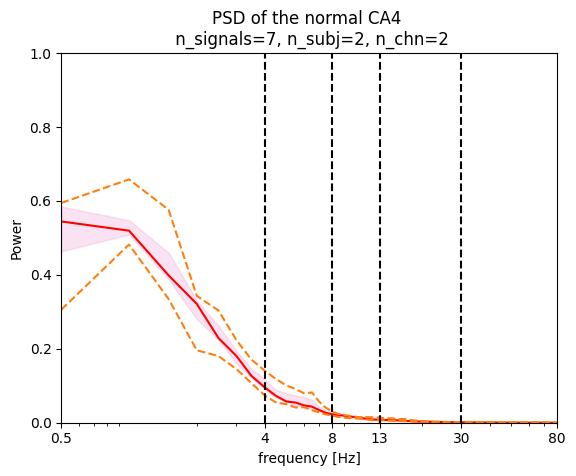

Unknown
['003' '003' '016' '016' '016' '016' '016' '016' '016' '016' '016' '016'
 '016' '016' '016' '016' '016' '067' '067' '067' '067' '067' '067' '067'
 '067' '067' '067' '068' '068' '068' '068' '068' '068' '078' '078' '078'
 '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078'
 '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078'
 '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078'
 '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078'
 '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078'
 '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078'
 '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078'
 '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078'
 '083' '083' '083' '083' '083' '083' '083' '083' '083' '083' '083' '083'
 '083' '083' '083' '083' '083' '083' '083' '083' '083' '083' '083' '083'
 '083' '083' '083' '083' '083' '083' '083' 

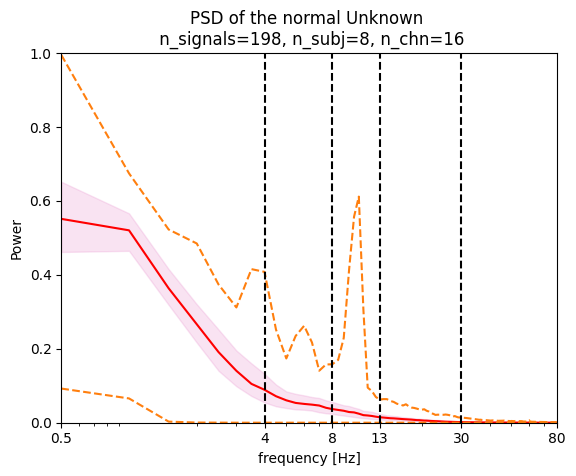

SRLM or 'dark band'
['016' '016' '016' '016' '016' '016' '016' '016' '016']
['RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2'
 'RAHc1-2' 'RAHc1-2']


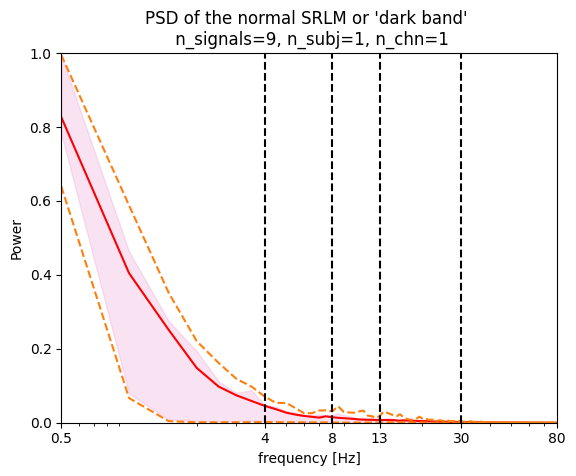

CA1
['016' '016' '016' '016' '016' '016' '016' '016' '016' '068' '068' '068'
 '068' '068' '068' '083' '083' '083' '083' '083' '083' '083' '083' '083'
 '083' '083' '093' '093' '093' '093' '093' '093' '093' '093' '093' '100'
 '100' '100' '100' '100' '100' '100' '100' '100' '100']
['RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3'
 'RAHc2-3' 'RAHc2-3' 'RHc1-2' 'RHc1-2' 'RHc1-2' 'RHc1-2' 'RHc1-2' 'RHc1-2'
 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2'
 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3'
 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'LPHc1-2'
 'RAHc1-2' 'LPHc1-2' 'RAHc1-2' 'LPHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2'
 'LPHc1-2' 'RAHc1-2']


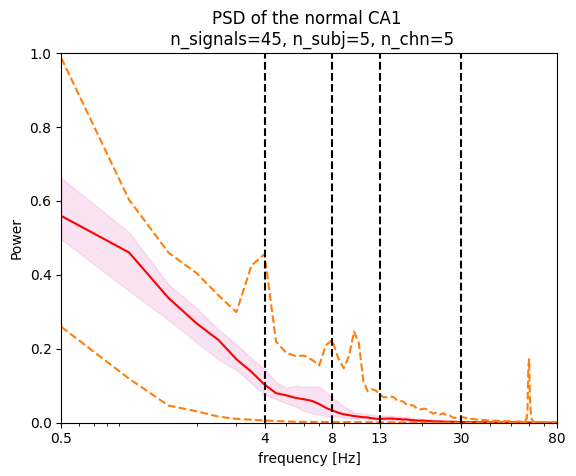

CA2
['078' '078' '078' '078' '078' '078' '078' '078' '078']
['LAHc3-4' 'LAHc3-4' 'LAHc3-4' 'LAHc3-4' 'LAHc3-4' 'LAHc3-4' 'LAHc3-4'
 'LAHc3-4' 'LAHc3-4']


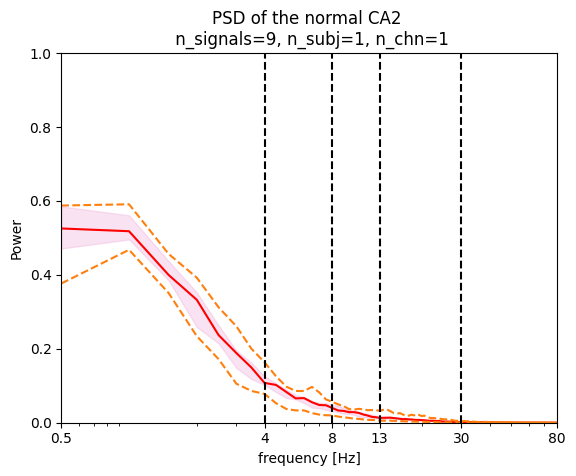

CA3
['093' '093' '093' '093' '093' '093' '093' '093' '093' '100' '100' '100'
 '100']
['RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2'
 'RAHc1-2' 'RAHc1-2' 'LPHc2-3' 'LPHc2-3' 'LPHc2-3' 'LPHc2-3']


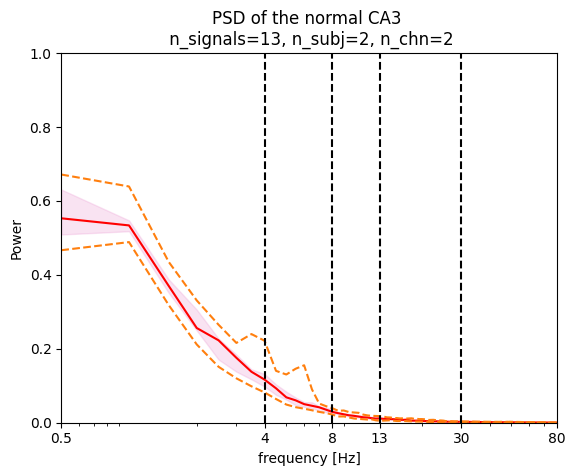

In [54]:
# Extract median, mean and std
median_region = {}
std_region = {}
mean_region = {}
for region in psd_per_region:
    # Extract data
    print(region)
    print(subj_per_region[region])
    print(chn_per_region[region])
    psd = psd_per_region[region]
    f = f_per_region[region]
    # # Plot and save the median curve
    n_subj = len(np.unique(subj_per_region[region]))
    n_chn = len(np.unique(chn_per_region[region]))
    median, mean, std = plotPaperFigures(f, psd, show_fig=True, title=f'PSD of the normal {region} \n n_signals={psd.shape[0]}, n_subj={n_subj}, n_chn={n_chn}')
    median_region[region] = median
    std_region[region] = std
    mean_region[region] = mean

## Abnormal signals

In [57]:
# Load snsx data
snsx_path = './snsx_data_collection.csv'
snsx_df = pd.read_csv(snsx_path, sep=',')
# Load mapping snsx to clinical
mapping = pd.read_csv('mapping_snsx_clinical.tsv', sep='\t')
abn_data_per_region = dict()
abn_subj_per_region = dict()
abn_chn_per_region = dict()
for sub_sess in sub_sess_info:
    # Get bad hemispheres
    subj_clinical = sub_sess_info[sub_sess]['subject']
    subj_snsx = 'sub-'+mapping_dict[f"P{subj_clinical}"]
    # print(subj_snsx)
    bilobal, bad_R, bad_L = snsx_df[snsx_df['participant_id']==subj_snsx][['Bilobal', 'Right ', 'Left']].to_numpy().squeeze().astype(bool)
    # print(bad_R, bad_L)
    # Get labels of electrodes with main region
    chn_region = []
    for chn in sub_sess_info[sub_sess]['chn_info']:
        chn_info = sub_sess_info[sub_sess]['chn_info'][chn]
        chn_region.append((chn, list(chn_info.keys())[0]))
    # Get info from channels.tsv
    loc_df = pd.read_csv(sub_sess_info[sub_sess]['channels_tsv'], sep='\t')
    # Get info per edf file
    for edf_path in sub_sess_info[sub_sess]['edf_files']:
        edf = pyedflib.EdfReader(edf_path)
        # Get chn labels
        edf_chns = edf.getSignalLabels()
        for chn, region in chn_region:
            # Check if the channel is in a good hemi
            # Right hemi
            cond_R = (loc_df[loc_df['label']==chn]['x_init'].values[0] > 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] > 0) and bad_R
            # Left hemi
            cond_L = (loc_df[loc_df['label']==chn]['x_init'].values[0] < 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] < 0) and bad_L
            if bilobal or (cond_R or cond_L):
                # print(cond_R, cond_L)
                # print(chn)
                data = edf.readSignal(edf_chns.index(chn))
                if region in abn_data_per_region:
                    abn_data_per_region[region].append(data)
                    abn_subj_per_region[region].append(subj_clinical)
                    abn_chn_per_region[region].append(chn)
                else:
                    abn_data_per_region[region] = [data]
                    abn_subj_per_region[region] = [subj_clinical]
                    abn_chn_per_region[region] = [chn]
        edf.close()

In [58]:
print(abn_data_per_region.keys())
print(abn_subj_per_region.keys())

dict_keys(['CA4', "SRLM or 'dark band'", 'Unknown', 'CA1', 'CA3', 'subiculum'])
dict_keys(['CA4', "SRLM or 'dark band'", 'Unknown', 'CA1', 'CA3', 'subiculum'])


In [59]:
for region in abn_data_per_region:
    abn_data_per_region[region] = np.array(abn_data_per_region[region])
    abn_subj_per_region[region] = np.array(abn_subj_per_region[region])
    abn_chn_per_region[region] = np.array(abn_chn_per_region[region])

In [60]:
psd_per_region_ab = dict()
f_per_region_ab =  dict()
for region in abn_data_per_region:
    f_per_region_ab[region], psd_per_region_ab[region] = welchMethod(abn_data_per_region[region], 200)

(142, 201)
(58, 201)
(566, 201)
(204, 201)
(38, 201)
(49, 201)


CA4
['003' '003' '003' '003' '013' '013' '013' '013' '013' '013' '013' '013'
 '013' '013' '013' '013' '013' '013' '013' '018' '018' '018' '018' '018'
 '018' '018' '018' '018' '018' '018' '018' '018' '018' '018' '018' '021'
 '021' '021' '021' '021' '021' '021' '021' '021' '021' '021' '021' '021'
 '021' '022' '022' '022' '022' '022' '022' '022' '022' '022' '022' '022'
 '022' '022' '022' '022' '022' '022' '022' '022' '022' '022' '022' '022'
 '022' '022' '022' '022' '022' '022' '022' '022' '022' '022' '022' '022'
 '022' '082' '082' '082' '082' '082' '082' '082' '082' '082' '082' '082'
 '082' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '087' '087' '087' '087' '087' '095' '095' '095' '095' '095'
 '103' '103' '103' '103' '103' '103' '103' '103' '103' '103' '103' '103'
 '103' '103' '103' '103' '103' '103' '103' '103' '103' '103']
['RAHc1-2' 'RAHc2-3' 'RAHc1-2' 'RAHc2-3' 'LAHc2-3' 'RAHc1-2' 'RAHc2-3'
 'LAHc2-3' 'RAHc1-2' 'RAHc2-3' 'LAHc2-3' 'RAHc1-2' 'RAHc2-3'

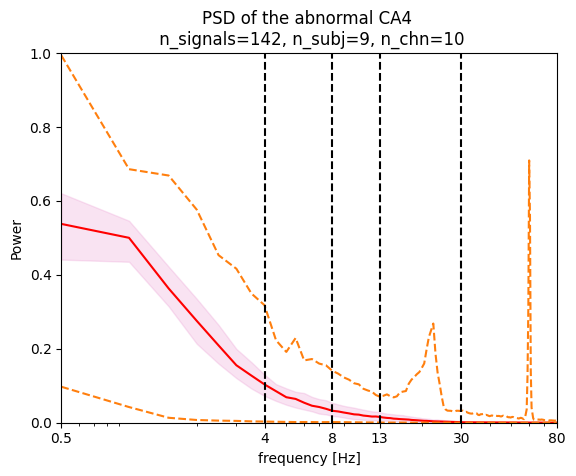

SRLM or 'dark band'
['003' '003' '020' '020' '020' '020' '020' '020' '020' '020' '020' '021'
 '021' '021' '021' '021' '021' '021' '021' '021' '021' '021' '021' '021'
 '021' '022' '022' '022' '022' '022' '022' '022' '022' '022' '083' '083'
 '083' '083' '083' '083' '083' '083' '083' '083' '083' '103' '103' '103'
 '103' '103' '103' '103' '103' '103' '103' '103' '103' '103']
['RAHc3-4' 'RAHc3-4' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2'
 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3'
 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3'
 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3' 'LT2PHc1-2' 'LT2PHc1-2'
 'LT2PHc1-2' 'LT2PHc1-2' 'LT2PHc1-2' 'LT2PHc1-2' 'LT2PHc1-2' 'LT2PHc1-2'
 'LT2PHc1-2' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2'
 'LPHc1-2' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2' 'RAHc1-2' 'RAHc1-2'
 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2'
 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2']


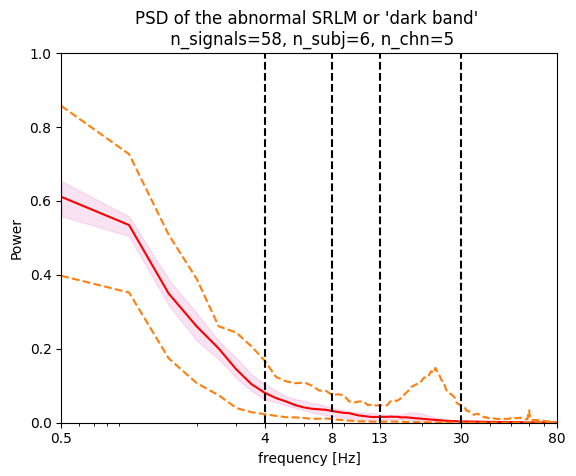

Unknown
['003' '003' '003' '003' '003' '003' '003' '003' '003' '003' '003' '003'
 '009' '009' '009' '009' '009' '009' '009' '009' '009' '009' '009' '009'
 '009' '009' '009' '009' '009' '009' '009' '009' '013' '013' '013' '013'
 '013' '013' '013' '013' '013' '013' '013' '013' '013' '013' '013' '013'
 '013' '013' '013' '013' '013' '013' '013' '013' '013' '013' '013' '013'
 '013' '013' '013' '013' '013' '013' '013' '018' '018' '018' '018' '018'
 '018' '018' '018' '018' '018' '018' '018' '018' '018' '018' '018' '018'
 '018' '018' '018' '018' '018' '018' '018' '018' '018' '018' '018' '018'
 '018' '018' '018' '020' '020' '020' '020' '020' '020' '020' '020' '020'
 '020' '020' '020' '020' '020' '020' '020' '020' '020' '020' '020' '020'
 '020' '020' '020' '020' '020' '020' '021' '021' '021' '021' '021' '021'
 '021' '021' '021' '021' '021' '021' '021' '021' '021' '021' '021' '021'
 '021' '021' '021' '021' '021' '021' '021' '021' '021' '021' '021' '021'
 '021' '021' '021' '021' '021' '021' '021' 

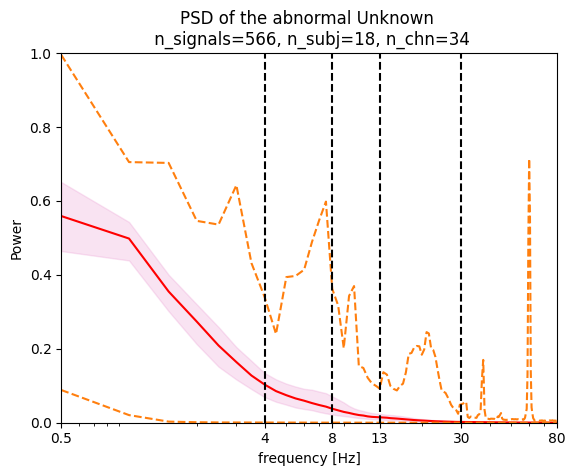

CA1
['003' '003' '003' '003' '013' '013' '013' '013' '013' '013' '013' '013'
 '013' '013' '013' '013' '013' '013' '013' '018' '018' '018' '018' '018'
 '018' '018' '018' '018' '018' '018' '018' '018' '018' '018' '018' '020'
 '020' '020' '020' '020' '020' '020' '020' '020' '020' '020' '020' '020'
 '020' '020' '020' '020' '020' '020' '020' '020' '020' '020' '020' '020'
 '020' '020' '020' '020' '020' '020' '020' '020' '020' '020' '020' '020'
 '020' '020' '020' '020' '020' '020' '020' '020' '021' '021' '021' '021'
 '021' '021' '021' '021' '021' '021' '021' '021' '021' '021' '065' '065'
 '081' '081' '081' '081' '081' '081' '081' '081' '081' '081' '081' '081'
 '081' '081' '081' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '087' '095' '095' '095' '095' '095' '103' '103' '103' '103'
 '103' '103' '103' '103' '103' '103' '103' '103

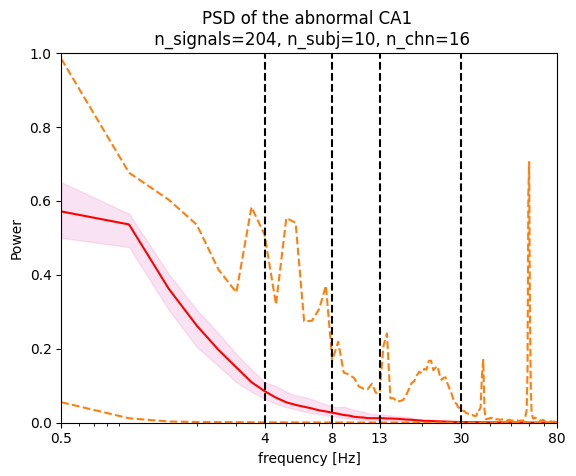

CA3
['013' '013' '013' '013' '013' '081' '081' '081' '081' '081' '082' '082'
 '082' '082' '082' '082' '082' '082' '082' '082' '082' '082' '095' '095'
 '095' '095' '095' '103' '103' '103' '103' '103' '103' '103' '103' '103'
 '103' '103']
['LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'RAHc1-2' 'RAHc1-2'
 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'LPHc4-5' 'LPHc5-6' 'LPHc4-5' 'LPHc5-6'
 'LPHc4-5' 'LPHc5-6' 'LPHc4-5' 'LPHc5-6' 'LPHc4-5' 'LPHc5-6' 'LPHc4-5'
 'LPHc5-6' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2'
 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2'
 'LAHc1-2' 'LAHc1-2' 'LAHc1-2']


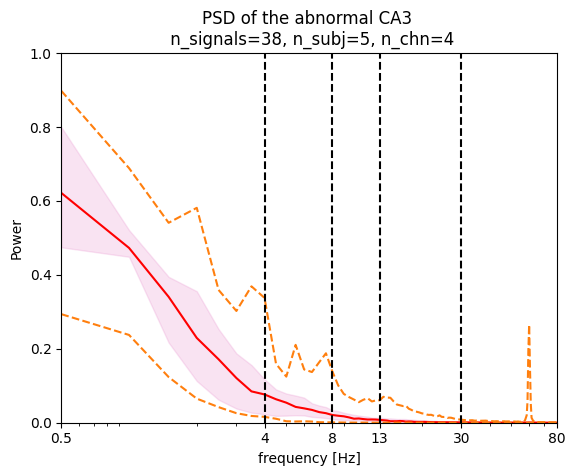

subiculum
['081' '081' '081' '081' '081' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '088' '088' '088' '088' '088' '088' '088' '088' '088' '103'
 '103' '103' '103' '103' '103' '103' '103' '103' '103' '103' '103' '103'
 '103' '103' '103' '103' '103' '103' '103' '103' '103' '103' '103' '103'
 '103']
['RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2'
 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2'
 'LAHc2-3' 'LAHc2-3' 'LAHc2-3' 'LAHc2-3' 'LAHc2-3' 'LAHc2-3' 'LAHc2-3'
 'LAHc2-3' 'LAHc2-3' 'RPHc1-2' 'RPHc2-3' 'RPHc1-2' 'RPHc2-3' 'RPHc1-2'
 'RPHc2-3' 'RPHc1-2' 'RPHc2-3' 'RPHc1-2' 'RPHc2-3' 'RPHc1-2' 'RPHc2-3'
 'RPHc1-2' 'RPHc2-3' 'RPHc1-2' 'RPHc2-3' 'RPHc1-2' 'RPHc2-3' 'RPHc1-2'
 'RPHc2-3' 'RPHc1-2' 'RPHc2-3' 'RPHc1-2' 'RPHc2-3' 'RPHc1-2' 'RPHc2-3']


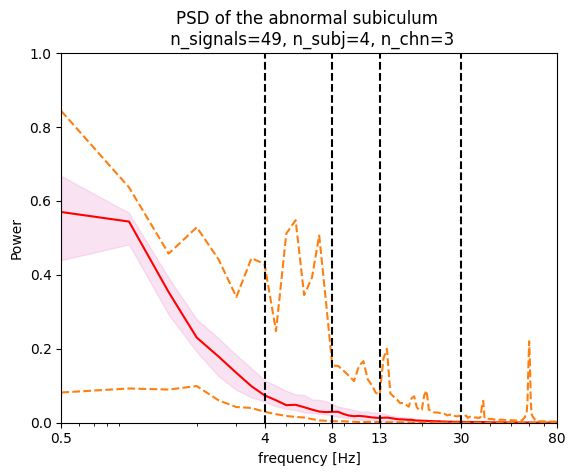

In [61]:
# Extract median, mean and std
median_region = {}
std_region = {}
mean_region = {}
for region in psd_per_region_ab:
    # Extract data
    print(region)
    print(abn_subj_per_region[region])
    print(abn_chn_per_region[region])
    psd = psd_per_region_ab[region]
    f = f_per_region_ab[region]
    # # Plot and save the median curve
    n_subj = len(np.unique(abn_subj_per_region[region]))
    n_chn = len(np.unique(abn_chn_per_region[region]))
    median, mean, std = plotPaperFigures(f, psd, show_fig=True, title=f'PSD of the abnormal {region} \n n_signals={psd.shape[0]}, n_subj={n_subj}, n_chn={n_chn}')
    median_region[region] = median
    std_region[region] = std
    mean_region[region] = mean

## Surface mapping

In [9]:
from pathlib import Path

In [5]:
def update_colortable_mask(final_mask, colortable_dict, scalar_val, chn, chn_mask, chn_colortable, subj):
    subj_chn = f'sub_{subj}-{chn}'
    if subj_chn in colortable_dict["sub_channel"]:
        return final_mask, colortable_dict, scalar_val
    else:
        old_mask = np.copy(final_mask)
        bool_mask = chn_mask.agg_data()==chn_colortable.loc[chn_colortable['channel']==chn, 'scalar'].values[0]
        final_mask[bool_mask] += scalar_val
        # Update colortable
        colortable_dict["scalar"].append(scalar_val)
        colortable_dict["sub_channel"].append(subj_chn)
        # Update in case of intersection
        if (final_mask > scalar_val).any():
            update_ids = final_mask > scalar_val
            old_ids = np.unique(old_mask[update_ids])
            for id_chn in old_ids:
                scalar_val += 1
                colortable_dict["scalar"].append(scalar_val)
                old_label = colortable_dict["sub_channel"][
                    colortable_dict["scalar"].index(id_chn)
                ]
                colortable_dict["sub_channel"].append(
                    old_label + "_" + subj_chn
                )
                # Update scalars in mask
                final_mask[(old_mask == id_chn) * update_ids] = scalar_val
        scalar_val += 1
        return final_mask, colortable_dict, scalar_val

In [10]:
# Load snsx data
snsx_path = './snsx_data_collection.csv'
snsx_df = pd.read_csv(snsx_path, sep=',')
# Load mapping snsx to clinical
mapping = pd.read_csv('mapping_snsx_clinical.tsv', sep='\t')
mapping_dict = dict(zip(mapping['ieeg_subject'].to_list(), mapping['snsx_subject'].to_list()))
# Generate a good and bad mask per hemi
mask_tmp = nb.load(sub_sess_info[list(sub_sess_info.keys())[0]]['mask_R'])
# good_R_mask = np.zeros(mask_tmp.agg_data().shape).astype(int)
# weighted_good_R_mask = np.zeros(mask_tmp.agg_data().shape).astype(float)
good_mask = np.zeros(mask_tmp.agg_data().shape).astype(int)

bad_mask =  np.zeros(mask_tmp.agg_data().shape).astype(int)
# bad_R_mask =  np.zeros(mask_tmp.agg_data().shape).astype(int)
# weighted_bad_R_mask =  np.zeros(mask_tmp.agg_data().shape).astype(float)

# mask_tmp = nb.load(sub_sess_info[list(sub_sess_info.keys())[0]]['mask_L'])
# good_L_mask = np.zeros(mask_tmp.agg_data().shape).astype(int)
# weighted_good_L_mask = np.zeros(mask_tmp.agg_data().shape).astype(float)

# bad_L_mask =  np.zeros(mask_tmp.agg_data().shape).astype(int)
# weighted_bad_L_mask =  np.zeros(mask_tmp.agg_data().shape).astype(float)

# # Scalars and colortables
# bad_scalar = 1
# bad_colortable = {"scalar": [], "sub_channel": []}
# good_scalar = 1
# good_colortable = {"scalar": [], "sub_channel": []}
# good_R_chns = set()
# good_L_chns = set()
# bad_R_chns = set()
# bad_L_chns = set()
good_chns = set()
bad_chns = set()

for sub_sess in sub_sess_info:
    # Get bad hemispheres
    subj_clinical = sub_sess_info[sub_sess]['subject']
    subj_snsx = 'sub-'+mapping_dict[f"P{subj_clinical}"]
    # print(subj_snsx)
    bilobal, bad_R, bad_L = snsx_df[snsx_df['participant_id']==subj_snsx][['Bilobal', 'Right ', 'Left']].to_numpy().squeeze().astype(bool)
    # print(bad_R, bad_L)
    # Get channels to extract:
    chns = list(sub_sess_info[sub_sess]['chn_info'].keys())
    if len(chns)>0:
        # Get info from channels.tsv
        loc_df = pd.read_csv(sub_sess_info[sub_sess]['channels_tsv'], sep='\t')
        # Load masks names
        filename = Path(sub_sess_info[sub_sess]['mask_R'])
        suffixes = "".join(filename.suffixes)
        mask_R_no_suffix = sub_sess_info[sub_sess]['mask_R'].replace(suffixes, "")
        filename = Path(sub_sess_info[sub_sess]['mask_L'])
        suffixes = "".join(filename.suffixes)
        mask_L_no_suffix = sub_sess_info[sub_sess]['mask_L'].replace(suffixes, "")
    # Filter channels in 'good' hemi
    for chn in chns:
        chn_label = f'sub_{subj_clinical}-{chn}'
        if chn_label not in good_chns and chn_label not in bad_chns:
            # Check if the channel is in a good hemi
            # Right hemi
            R_elec = (loc_df[loc_df['label']==chn]['x_init'].values[0] > 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] > 0)
            cond_R = R_elec and not bad_R
            # Left hemi
            L_elec = (loc_df[loc_df['label']==chn]['x_init'].values[0] < 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] < 0)
            cond_L = L_elec and not bad_L
            # Good chn
            if not bilobal and (cond_R or cond_L):
                # Right electrode
                if R_elec:
                    chn_mask = mask_R_no_suffix + '_chn-' + chn + suffixes
                    chn_mask = nb.load(chn_mask).agg_data()
                    # good_R_mask [chn_mask>0] += 1
                    # weighted_good_R_mask += chn_mask
                    good_mask[chn_mask>0] += 1
                    #add to set
                    # good_R_chns.add(chn_label)
                    good_chns.add(chn_label)

                # Left electrode
                else:
                    chn_mask = mask_L_no_suffix + '_chn-' + chn + suffixes
                    chn_mask = nb.load(chn_mask).agg_data()
                    # good_L_mask[chn_mask>0] += 1
                    # weighted_good_L_mask += chn_mask
                    good_mask[chn_mask>0] += 1

                    # good_L_chns.add(chn_label)
                    good_chns.add(chn_label)
            # Bad chn
            else:
                # Right electrode
                if R_elec:
                    chn_mask = mask_R_no_suffix + '_chn-' + chn + suffixes
                    chn_mask = nb.load(chn_mask).agg_data()
                    # bad_R_mask[chn_mask>0] += 1
                    # weighted_bad_R_mask += chn_mask
                    bad_mask[chn_mask>0] += 1

                    bad_chns.add(chn_label)
                # Left electrode
                else:
                    chn_mask = mask_L_no_suffix + '_chn-' + chn + suffixes
                    chn_mask = nb.load(chn_mask).agg_data()
                    # bad_L_mask[chn_mask>0] += 1
                    # weighted_bad_L_mask += chn_mask
                    bad_mask[chn_mask>0] += 1

                    bad_chns.add(chn_label)
# Updated weighted masks
# weighted_good_R_mask[weighted_good_R_mask>0] = np.divide(weighted_good_R_mask[weighted_good_R_mask>0], good_R_mask[good_R_mask>0])
# weighted_good_L_mask[weighted_good_L_mask>0] = np.divide(weighted_good_L_mask[weighted_good_L_mask>0], good_L_mask[good_L_mask>0])
# weighted_bad_R_mask[weighted_bad_R_mask>0] = np.divide(weighted_bad_R_mask[weighted_bad_R_mask>0], bad_R_mask[bad_R_mask>0])
# weighted_bad_L_mask[weighted_bad_L_mask>0] = np.divide(weighted_bad_L_mask[weighted_bad_L_mask>0], bad_L_mask[bad_L_mask>0])
# # Normalize masks
# good_R_mask[good_R_mask>0] = 1
# good_L_mask[good_L_mask>0] = 1
# bad_R_mask[bad_R_mask>0] = 1
# bad_L_mask[bad_L_mask>0] = 1

In [11]:
# print(len(good_R_chns))
# print(len(good_L_chns))
# print(len(bad_R_chns))
# print(len(bad_L_chns))
print(len(bad_chns))
print(len(good_chns))

139
39


In [66]:
# Save gifti files
masks = [good_R_mask, good_L_mask, bad_R_mask, bad_L_mask]
names = ['good_R_mask', 'good_L_mask', 'bad_R_mask', 'bad_L_mask']
mask_tmp_R = nb.load(sub_sess_info[list(sub_sess_info.keys())[0]]['mask_R'])
mask_tmp_L = nb.load(sub_sess_info[list(sub_sess_info.keys())[0]]['mask_L'])
masks_tmp = [mask_tmp_R, mask_tmp_L, mask_tmp_R, mask_tmp_L]
for mask, name, mask_tmp in zip(masks, names, masks_tmp):
    darray = nb.gifti.gifti.GiftiDataArray(data=mask.astype(np.float32))
    labeltable = nb.gifti.gifti.GiftiLabelTable()
    # Add unknown
    glabel = nb.gifti.GiftiLabel(0)
    glabel.label = 'Unknown'
    labeltable.labels.append(glabel)
    # Add electrode
    glabel = nb.gifti.GiftiLabel(0)
    glabel.label = 'Electrode'
    labeltable.labels.append(glabel)

    gifti_obj = mask_tmp #nb.gifti.gifti.GiftiImage(darrays=[darray], header=mask_tmp._header) #
    gifti_obj.darrays = [darray]
    gifti_obj.labeltable= labeltable
    nb.save(gifti_obj, f'Results/{name}.shape.gii')

In [67]:
# Save gifti files
masks = [weighted_good_R_mask, weighted_good_L_mask, weighted_bad_R_mask, weighted_bad_L_mask]
names = ['weighted_good_R_mask', 'weighted_good_L_mask', 'weighted_bad_R_mask', 'weighted_bad_L_mask']
mask_tmp_R = nb.load(sub_sess_info[list(sub_sess_info.keys())[0]]['mask_R'])
mask_tmp_L = nb.load(sub_sess_info[list(sub_sess_info.keys())[0]]['mask_L'])
masks_tmp = [mask_tmp_R, mask_tmp_L, mask_tmp_R, mask_tmp_L]
for mask, name, mask_tmp in zip(masks, names, masks_tmp):
    darray = nb.gifti.gifti.GiftiDataArray(data=mask.astype(np.float32))

    gifti_obj = mask_tmp #nb.gifti.gifti.GiftiImage(darrays=[darray], header=mask_tmp._header) #
    gifti_obj.darrays = [darray]
    nb.save(gifti_obj, f'Results/{name}.shape.gii')

In [12]:
# Save gifti files
masks = [good_mask, bad_mask]
names = ['good_electrodes_count', 'bad_electrodes_count']
mask_tmp_R = nb.load(sub_sess_info[list(sub_sess_info.keys())[0]]['mask_R'])
mask_tmp_L = nb.load(sub_sess_info[list(sub_sess_info.keys())[0]]['mask_L'])
masks_tmp = [mask_tmp_R, mask_tmp_L]
for mask, name, mask_tmp in zip(masks, names, masks_tmp):
    darray = nb.gifti.gifti.GiftiDataArray(data=mask.astype(np.float32))

    gifti_obj = mask_tmp #nb.gifti.gifti.GiftiImage(darrays=[darray], header=mask_tmp._header) #
    gifti_obj.darrays = [darray]
    nb.save(gifti_obj, f'Results/{name}.shape.gii')

In [111]:
gifti_obj.labeltable

<GiftiLabelTable [<GiftiLabel 0="#00000000">, <GiftiLabel 1="#b1e3ec01">, <GiftiLabel 2="#a138e801">, <GiftiLabel 3="#165f7e01">, <GiftiLabel 4="#17bce401">, <GiftiLabel 5="#9083ae01">, <GiftiLabel 6="#35b8e401">, <GiftiLabel 7="#b49a9401">, <GiftiLabel 8="#07b6c301">, <GiftiLabel 9="#1768dd01">, <GiftiLabel 10="#0e9cfb01">, <GiftiLabel 11="#e1c0d601">, <GiftiLabel 12="#756d0c01">, <GiftiLabel 13="#aaa5a901">, <GiftiLabel 14="#ccbd7701">, <GiftiLabel 15="#b1e1cf01">]>

## Gifti PSD

In [68]:
# Load snsx data
snsx_path = './snsx_data_collection.csv'
snsx_df = pd.read_csv(snsx_path, sep=',')
# Load mapping snsx to clinical
mapping = pd.read_csv('mapping_snsx_clinical.tsv', sep='\t')
mapping_dict = dict(zip(mapping['ieeg_subject'].to_list(), mapping['snsx_subject'].to_list()))
# Generate a good and bad mask per hemi

good_psd = np.zeros(mask_tmp.agg_data().shape).astype(float)
weights_good_mask = np.zeros(mask_tmp.agg_data().shape).astype(float)

bad_psd = np.zeros(mask_tmp.agg_data().shape).astype(float)
weights_bad_mask = np.zeros(mask_tmp.agg_data().shape).astype(float)

good_psd_gif = np.zeros((mask_tmp.agg_data().shape[0], 159)).astype(float)

bad_psd_gif = np.zeros((mask_tmp.agg_data().shape[0], 159)).astype(float)
# # Scalars and colortables
# bad_scalar = 1
# bad_colortable = {"scalar": [], "sub_channel": []}
# good_scalar = 1
# good_colortable = {"scalar": [], "sub_channel": []}
good_R_chns = set()
good_L_chns = set()
bad_R_chns = set()
bad_L_chns = set()

for sub_sess in sub_sess_info:
    # Get bad hemispheres
    subj_clinical = sub_sess_info[sub_sess]['subject']
    subj_snsx = 'sub-'+mapping_dict[f"P{subj_clinical}"]
    # print(subj_snsx)
    bilobal, bad_R, bad_L = snsx_df[snsx_df['participant_id']==subj_snsx][['Bilobal', 'Right ', 'Left']].to_numpy().squeeze().astype(bool)
    # print(bad_R, bad_L)
    # Get channels to extract:
    chns = list(sub_sess_info[sub_sess]['chn_info'].keys())
    if len(chns)>0:
        # Get info from channels.tsv
        loc_df = pd.read_csv(sub_sess_info[sub_sess]['channels_tsv'], sep='\t')
        # Load masks names
        filename = Path(sub_sess_info[sub_sess]['mask_R'])
        suffixes = "".join(filename.suffixes)
        mask_R_no_suffix = sub_sess_info[sub_sess]['mask_R'].replace(suffixes, "")
        filename = Path(sub_sess_info[sub_sess]['mask_L'])
        suffixes = "".join(filename.suffixes)
        mask_L_no_suffix = sub_sess_info[sub_sess]['mask_L'].replace(suffixes, "")
    
    # Get edf objs
    # edf_objs = [pyedflib.EdfReader(edf_path) for edf_path in sub_sess_info[sub_sess]['edf_files']]
    
    # Filter channels in 'good' hemi
    for chn in chns:
        chn_label = f'sub_{subj_clinical}-{chn}'
        # Check if the channel is in a good hemi
        # Right hemi
        R_elec = (loc_df[loc_df['label']==chn]['x_init'].values[0] > 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] > 0)
        cond_R = R_elec and not bad_R
        # Left hemi
        L_elec = (loc_df[loc_df['label']==chn]['x_init'].values[0] < 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] < 0)
        cond_L = L_elec and not bad_L
        
        # Load data from edf
        for edf_path in sub_sess_info[sub_sess]['edf_files']:
            edf = pyedflib.EdfReader(edf_path)
            # welchMethod(data_per_region[region], 200)
            # Get chn labels from edf
            edf_chns = edf.getSignalLabels()
            # print(edf_chns.index(chn))
            # Get channel information
            chn_signal = edf.readSignal(edf_chns.index(chn))
            edf.close()
            chn_freq, chn_psd = welchMethod(chn_signal, 200)
            # Get average value in band 0.5 to 4
            freq_mask = (chn_freq>0.5) * (chn_freq<=4)
            chn_data = np.mean(chn_psd[freq_mask])
            # Good chn
            if not bilobal and (cond_R or cond_L):
                # Right electrode
                if R_elec:
                    chn_mask = mask_R_no_suffix + '_chn-' + chn + suffixes
                    chn_mask = nb.load(chn_mask).agg_data()
                    # good_R_psd += chn_mask*chn_data
                    # weights_good_R_mask += chn_mask
                    
                    #add to set
                    good_R_chns.add(chn_label)

                # Left electrode
                else:
                    chn_mask = mask_L_no_suffix + '_chn-' + chn + suffixes
                    chn_mask = nb.load(chn_mask).agg_data()
                    # good_L_psd += chn_mask*chn_data
                    # weights_good_L_mask += chn_mask

                    good_L_chns.add(chn_label)
                
                good_psd += chn_mask*chn_data
                weights_good_mask += chn_mask
                
                # For gif
                for f_id in range(len(chn_freq)):
                    good_psd_gif[:,f_id] += chn_mask*chn_psd[f_id]
            # Bad chn
            else:
                # Right electrode
                if R_elec:
                    chn_mask = mask_R_no_suffix + '_chn-' + chn + suffixes
                    chn_mask = nb.load(chn_mask).agg_data()
                    # bad_R_psd += chn_mask*chn_data
                    # weights_bad_R_mask += chn_mask

                    bad_R_chns.add(chn_label)
                # Left electrode
                else:
                    chn_mask = mask_L_no_suffix + '_chn-' + chn + suffixes
                    chn_mask = nb.load(chn_mask).agg_data()
                    # bad_L_psd += chn_mask*chn_data
                    # weights_bad_L_mask += chn_mask

                    bad_L_chns.add(chn_label)
                
                bad_psd += chn_mask*chn_data
                weights_bad_mask += chn_mask

                # For gif
                for f_id in range(len(chn_freq)):
                    bad_psd_gif[:,f_id] += chn_mask*chn_psd[f_id]

(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)
(201,)

In [69]:
len(chn_psd)

159

In [71]:
# Update masks with weights
# good_R_psd = np.divide(good_R_psd, weights_good_R_mask, out=np.zeros_like(good_R_psd), where=weights_good_R_mask!=0)
# good_L_psd = np.divide(good_L_psd, weights_good_L_mask, out=np.zeros_like(good_L_psd), where=weights_good_L_mask!=0)
# bad_R_psd = np.divide(bad_R_psd, weights_bad_R_mask, out=np.zeros_like(bad_R_psd), where=weights_bad_R_mask!=0)
# bad_L_psd = np.divide(bad_L_psd, weights_bad_L_mask, out=np.zeros_like(bad_L_psd), where=weights_bad_L_mask!=0)

good_psd = np.divide(good_psd, weights_good_mask, out=np.zeros_like(good_psd), where=weights_good_mask!=0)
bad_psd = np.divide(bad_psd, weights_bad_mask, out=np.zeros_like(bad_psd), where=weights_bad_mask!=0)

In [72]:
for freq_id in range(good_psd_gif.shape[-1]):
    good_psd_gif[:,freq_id] = np.divide(good_psd_gif[:,freq_id], weights_good_mask, out=np.zeros_like(good_psd), where=weights_good_mask!=0)
    bad_psd_gif[:,freq_id] = np.divide(bad_psd_gif[:,freq_id], weights_bad_mask, out=np.zeros_like(bad_psd), where=weights_bad_mask!=0)

In [73]:
good_psd_gif.shape

(7262, 159)

In [74]:
np.save('Results/good_psd_gif.npy', good_psd_gif)
np.save('Results/bad_psd_gif.npy', bad_psd_gif)

In [75]:
# Save gifti files
masks = [good_psd, bad_psd] #good_R_psd, good_L_psd, bad_R_psd, bad_L_psd, 
names = ['good_psd', 'bad_psd'] #'good_R_psd', 'good_L_psd', 'bad_R_psd', 'bad_L_psd', 
mask_tmp_R = nb.load(sub_sess_info[list(sub_sess_info.keys())[0]]['mask_R'])
mask_tmp_L = nb.load(sub_sess_info[list(sub_sess_info.keys())[0]]['mask_L'])
masks_tmp = [mask_tmp_R, mask_tmp_L] #, mask_tmp_R, mask_tmp_L, mask_tmp_R, mask_tmp_L
for mask, name, mask_tmp in zip(masks, names, masks_tmp):
    darray = nb.gifti.gifti.GiftiDataArray(data=mask.astype(np.float32))

    gifti_obj = mask_tmp #nb.gifti.gifti.GiftiImage(darrays=[darray], header=mask_tmp._header) #
    gifti_obj.darrays = [darray]
    nb.save(gifti_obj, f'Results/{name}.shape.gii')

## Visualize PSD

In [1]:
import numpy as np
import nibabel as nib
import sys
from hippunfold_toolbox import utils, plotting
import importlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
surf_file = '/scratch/mcesped/Results/hippunfold/batch-hippunfold/hippunfold/sub-P060/surf/sub-P060_hemi-R_space-unfold_den-0p5mm_label-hipp_midthickness.surf.gii'
gii = nib.load(surf_file)
vertices = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
faces = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data

In [8]:
vertices.shape

(7262, 3)

/tmp/ipykernel_5535/4057233523.py:5: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


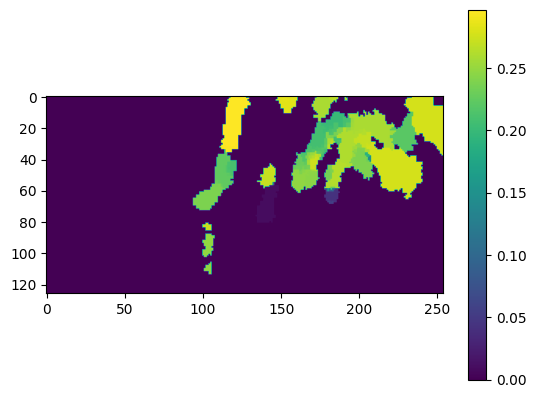

In [3]:
APaxis=0
w = 126
s=5
Pold = vertices[:,APaxis] 
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
from numpy.matlib import repmat


psd = nib.load('good_psd.shape.gii').darrays[0].data
den='0p5mm'
label='hipp'
psd,_,_ = utils.density_interp(den, 'unfoldiso', psd.flatten(), label, 'nearest')
psd_good = np.reshape(psd,(w,254))

# psd = gaussian_filter(psd,sigma=s)
plt.imshow(psd_good[::-1,::-1])
plt.colorbar()

In [101]:
image_array = psd[::-1,::-1].copy()

In [102]:
image_array.shape

(126, 254)

In [103]:
grid_x, grid_y = np.mgrid[0:126, 0:254]
grid_y

array([[  0,   1,   2, ..., 251, 252, 253],
       [  0,   1,   2, ..., 251, 252, 253],
       [  0,   1,   2, ..., 251, 252, 253],
       ...,
       [  0,   1,   2, ..., 251, 252, 253],
       [  0,   1,   2, ..., 251, 252, 253],
       [  0,   1,   2, ..., 251, 252, 253]])

In [104]:
mask_values = np.round(image_array,2) > 0
known_x, known_y = np.where(mask_values)
known_y

array([118, 119, 120, ..., 105, 104, 105])

In [105]:
points = np.array(list(zip(known_x, known_y)))
points

array([[  0, 118],
       [  0, 119],
       [  0, 120],
       ...,
       [112, 105],
       [113, 104],
       [113, 105]])

In [106]:
values = [image_array[x, y] for x,y in points]
values = np.array(values)
values

array([0.29675356, 0.29675356, 0.29675356, ..., 0.24871142, 0.24871142,
       0.24871142], dtype=float32)

In [107]:
from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

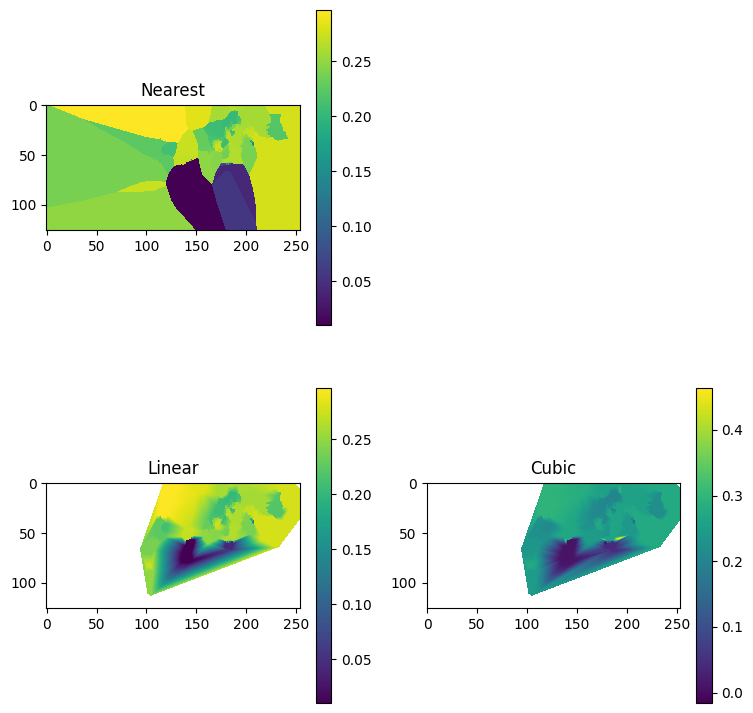

In [111]:
plt.subplot(221)
plt.imshow(grid_z0)
plt.colorbar()
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1)
plt.colorbar()
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2)
plt.colorbar()
plt.title('Cubic')
plt.gcf().set_size_inches(9, 9)
plt.show()

/tmp/ipykernel_2251/450556579.py:5: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


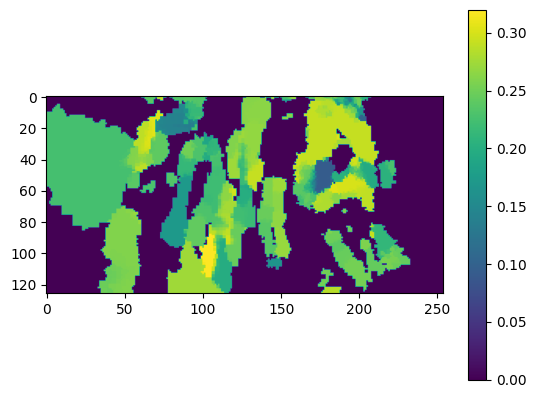

In [5]:
APaxis=0
w = 126
s=6
Pold = vertices[:,APaxis] 
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
from numpy.matlib import repmat


psd = nib.load('bad_psd.shape.gii').darrays[0].data
den='0p5mm'
label='hipp'
psd,_,_ = utils.density_interp(den, 'unfoldiso', psd.flatten(), label, 'nearest')
bad_psd = np.reshape(psd,(w,254))

# psd = gaussian_filter(psd,sigma=s)
plt.imshow(bad_psd[::-1,::-1])
plt.colorbar()

In [55]:
image_array = psd[::-1,::-1].copy()
grid_x, grid_y = np.mgrid[0:126, 0:254]

mask_values = image_array > 0
known_x, known_y = np.where(mask_values)

points = np.array(list(zip(known_x, known_y)))
values = [image_array[x, y] for x,y in points]
values = np.array(values)

from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

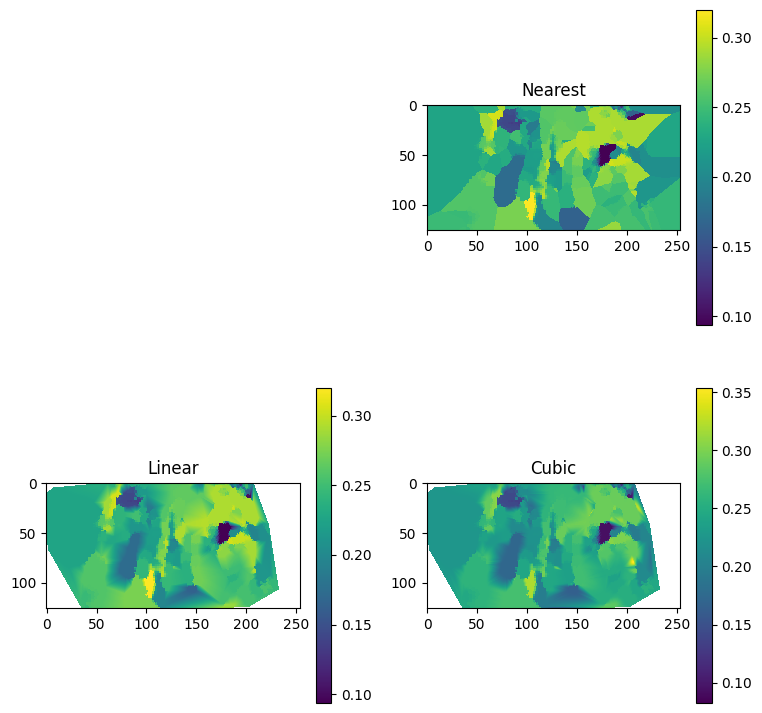

In [58]:
plt.subplot(222)
plt.imshow(grid_z0)
plt.colorbar()
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1)
plt.title('Linear')
plt.colorbar()
plt.subplot(224)
plt.imshow(grid_z2)
plt.title('Cubic')
plt.colorbar()
plt.gcf().set_size_inches(9, 9)
plt.show()

In [2]:
# Plots in 3D
# this is an array with the shape Vx2xSxF, where V is the number of vertices, 2 is the
# number of hemispheres, S is the number of subjects, and F is a stack of different features.
psd_good = nib.load('good_psd.shape.gii').darrays[0].data
psd_bad = nib.load('bad_psd.shape.gii').darrays[0].data

# Reshape
psd_good = np.expand_dims(psd_good, axis=1)
psd_bad = np.expand_dims(psd_bad, axis=1)

In [3]:
psd_total = np.concatenate([psd_good, psd_bad], axis=1)
psd_total.shape

(7262, 2)

In [4]:
psd_total = np.expand_dims(psd_total, axis=2)
# psd_total = np.expand_dims(psd_total, axis=3)
# psd_total = np.concatenate([psd_total, psd_total], axis=3)
psd_total.shape

(7262, 2, 1)

In [5]:
averaged_data = np.mean(psd_total,axis=2)
averaged_data.shape

(7262, 2)

In [ ]:
plotting.surfplot_canonical_foldunfold(psd_total, labels=[1,2,3], embed_nb=True, color_bar='right', share='row')

## Location in template space

In [1]:
from bids import BIDSLayout
import pandas as pd
import numpy as np
import scipy
import json
import pyedflib
import re
import nibabel as nb
import os
import SimpleITK as sitk
import mne

In [2]:
# Load dataset
data_path = '/scratch/mcesped/Results/seegprep/hipp_run/bids/'
layout = BIDSLayout(data_path, validate=False)

In [3]:
data_path = '/scratch/mcesped/Results/seegprep/hipp_run/work/'
layout_work = BIDSLayout(data_path, validate=False) 

In [4]:
# Get all json files
json_files = layout.get(extension='json')
json_files[0:3]

[<BIDSJSONFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-002/ses-002/ieeg/sub-002_ses-002_task-full_rec-regionID_run-01_regions_native_space.json'>,
 <BIDSJSONFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-003/ses-007/ieeg/sub-003_ses-007_task-full_rec-regionID_run-02_regions_native_space.json'>,
 <BIDSJSONFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-003/ses-008/ieeg/sub-003_ses-008_task-full_rec-regionID_run-01_regions_native_space.json'>]

In [5]:
sub_sess_info = dict()
json_files = layout.get(extension='json')
for json_file in json_files:
    # Open json
    with open(json_file.path, 'r') as f:
      data_json = json.load(f)
    # Filter data in dict
    new_dict = data_json.copy()
    for key in data_json:
        keys_chn = list(data_json[key].keys())
        # Filter unknown
        if keys_chn[0] == 'Unknown' and len(keys_chn)<=1:
            del new_dict[key]
    # Extract location files
    subj = json_file.get_entities()['subject']
    session = json_file.get_entities()['session']
    run = json_file.get_entities()['run']
    loc_file = layout.get(extension='tsv', suffix='space', subject=subj, session=session, run=run, return_type='filename')
    # Get transforms 
    affine_file = layout_work.get(extension='txt', suffix='affine', subject=subj, return_type='filename')
    reg = re.compile(r'ras')                    # Compile the regex
    affine_file = list(filter(reg.search, affine_file))[0]
    inwarp_file = layout_work.get(extension='nii.gz', suffix='invwarp', subject=subj, return_type='filename')[0]

    if len(loc_file)>1:
        print('Ups this is wrong')
    # Append to dict
    if len(new_dict) > 0:
        sub_sess_info[f'sub-{subj}_ses-{session}_run-{run}'] = {
            'channels_tsv': loc_file[0],
            'affine': affine_file,
            'inwarp': inwarp_file,
            'chn_info': new_dict,
            'subject': subj
        }

In [6]:
sub_sess_info

{'sub-003_ses-007_run-02': {'channels_tsv': '/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-003/ses-007/ieeg/sub-003_ses-007_task-full_rec-regionID_run-02_regions_native_space.tsv',
  'affine': '/scratch/mcesped/Results/seegprep/hipp_run/work/sub-003/warps/sub-003_desc-ras_from-subject_to-MNI152NLin2009cAsym_affine.txt',
  'inwarp': '/scratch/mcesped/Results/seegprep/hipp_run/work/sub-003/warps/sub-003_from-subject_to-MNI152NLin2009cAsym_invwarp.nii.gz',
  'chn_info': {'LAHc1-2': {'CA4': 0.28,
    'CA1': 0.27,
    'CA3': 0.26,
    "SRLM or 'dark band'": 0.16,
    'dentate gyrus': 0.02,
    'Unknown': 0.01,
    'CA2': 0.0},
   'LAHc2-3': {'Unknown': 0.57,
    'CA1': 0.27,
    "SRLM or 'dark band'": 0.15,
    'dentate gyrus': 0.01,
    'CA2': 0.0},
   'RAHc1-2': {'CA4': 0.54,
    "SRLM or 'dark band'": 0.2,
    'CA3': 0.1,
    'CA1': 0.09,
    'dentate gyrus': 0.07},
   'RAHc2-3': {'CA4': 0.6,
    "SRLM or 'dark band'": 0.25,
    'dentate gyrus': 0.08,
    'CA3': 0.07,
    'CA1': 0.

In [7]:
# Function to read matrix
def readRegMatrix(trsfPath):
	with open(trsfPath) as (f):
		return np.loadtxt(f.readlines())

In [13]:
output_fiducial_file = 'electrodes_MNI152NLin2009cAsym.fcsv'


# Template string
template = '''# Markups fiducial file version = 4.10
# CoordinateSystem = 0
# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID
'''

# Replace coordinates in the template dynamically
replaced_template = template

count_fiducials = 0
chns_computed = []
for subj_ses in sub_sess_info:
    channels_tsv = pd.read_csv(sub_sess_info[subj_ses]['channels_tsv'], sep='\t')
    channels_get = list(sub_sess_info[subj_ses]['chn_info'].keys())
    subj = sub_sess_info[subj_ses]['subject']
    # Get transform list 
    tfm_list = [(sub_sess_info[subj_ses]['affine'], True), (sub_sess_info[subj_ses]['inwarp'], False)]
    # Iterate over channels
    for chn in channels_get:
        # Get unipolar chns
        pattern = [
                r"([A-Z0-9]+[-]+)(\d+)-(\d+)$",
                r"([A-Z]+[-]*)(\d+)-(\d+)$",
                r"([A-Z]+[0-9]+[A-Z]+[-]*)(\d+)-(\d+)$",
            ]
        match = None
        n = 0
        while (not match) and (n < len(pattern)):
            match = re.match(pattern[n], chn, re.IGNORECASE)
            n += 1
        if not match:
            raise Exception(f"Channel {chn} did not match any of the regex.")
        # Build labels
        label_chn1 = f'sub-{subj}_{match.groups()[0]}{match.groups()[1]}'
        label_chn2 = f'sub-{subj}_{match.groups()[0]}{match.groups()[2]}'
        # For initial chn
        if label_chn1 not in chns_computed or label_chn2 not in chns_computed:
            # Get positions
            mri_ras_mm = channels_tsv.loc[channels_tsv['label']==chn, ['x_init','y_init','z_init', 'x_end', 'y_end', 'z_end']].values.reshape(2,-1)
            # Apply transforms
            for tfm, inv_bool in tfm_list:
                if type(tfm)==str:
                    if tfm.endswith('txt'):
                        tfm = readRegMatrix(tfm)
                        if inv_bool:
                            tfm = np.linalg.inv(tfm)
                        mri_ras_mm = mne.transforms.apply_trans(tfm, mri_ras_mm)
                    elif tfm.endswith('nii.gz'):
                        #reads the transform and casts the output compaitble format
                        transform_image = sitk.ReadImage(tfm)
                        transform_image = sitk.Cast(transform_image, sitk.sitkVectorFloat64)
                        # load it as a transform
                        identity_transform = sitk.Transform(transform_image)
                        # Convert points from RAS to LPS
                        mri_mni_lps = mri_ras_mm * np.array([-1, -1, 1])
                        # Transform
                        for point_id in range(mri_mni_lps.shape[0]):
                            mri_mni_lps[point_id, :] = np.array(identity_transform.TransformPoint(mri_mni_lps[point_id, :]))
                        # Convert from LPS back to RAS
                        mri_ras_mm = mri_mni_lps * np.array([-1, -1, 1])
                else:
                    if inv_bool:
                        tfm = np.linalg.inv(tfm)
                    mri_ras_mm = mne.transforms.apply_trans(tfm, mri_ras_mm)
            
            # Add channels if not added before
            for idx, label_chn in enumerate([label_chn1, label_chn2]):
                if label_chn not in chns_computed:
                    line = f"vtkMRMLMarkupsFiducialNode_{count_fiducials},{mri_ras_mm[idx,0]},{mri_ras_mm[idx,1]},{mri_ras_mm[idx,2]},0.000,0.000,0.000,1.000,1,1,0,{label_chn},,vtkMRMLScalarVolumeNode1\n"
                    replaced_template += line
                    count_fiducials += 1
                    chns_computed.append(label_chn)


In [14]:
print(replaced_template)

# Markups fiducial file version = 4.10
# CoordinateSystem = 0
# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID
vtkMRMLMarkupsFiducialNode_0,-30.694521586411046,-17.00651874288053,-15.161258291579871,0.000,0.000,0.000,1.000,1,1,0,sub-003_LAHc1,,vtkMRMLScalarVolumeNode1
vtkMRMLMarkupsFiducialNode_1,-35.30698314908646,-16.747410361750525,-14.984665196062533,0.000,0.000,0.000,1.000,1,1,0,sub-003_LAHc2,,vtkMRMLScalarVolumeNode1
vtkMRMLMarkupsFiducialNode_2,-39.02419024459431,-16.609066494909044,-15.40153564590729,0.000,0.000,0.000,1.000,1,1,0,sub-003_LAHc3,,vtkMRMLScalarVolumeNode1
vtkMRMLMarkupsFiducialNode_3,21.198218912847892,-15.438877812561955,-19.66026540335476,0.000,0.000,0.000,1.000,1,1,0,sub-003_RAHc1,,vtkMRMLScalarVolumeNode1
vtkMRMLMarkupsFiducialNode_4,26.809956227459164,-15.97348623123709,-20.26139186656898,0.000,0.000,0.000,1.000,1,1,0,sub-003_RAHc2,,vtkMRMLScalarVolumeNode1
vtkMRMLMarkupsFiducialNode_5,31.427897755556643,-15.158356759982729,-19.635630

In [15]:
# Save the replaced template to a file
with open(output_fiducial_file, 'w') as file:
    file.write(replaced_template)

print("Transformed fiducial points saved to:", output_fiducial_file)

Transformed fiducial points saved to: electrodes_MNI152NLin2009cAsym.fcsv


In [8]:
subj_ses = 'sub-003_ses-007_run-02'
channels_tsv = pd.read_csv(sub_sess_info[subj_ses]['channels_tsv'], sep='\t')
channels_get = list(sub_sess_info[subj_ses]['chn_info'].keys())
subj = sub_sess_info[subj_ses]['subject']
# Get transform list 
tfm_list = [(sub_sess_info[subj_ses]['affine'], True), (sub_sess_info[subj_ses]['inwarp'], False)]

In [9]:
channels_tsv.head()

,type,group,label,x_init,x_end,y_init,y_end,z_init,z_end,region ID,region name,r,g,b
0,SEEGA,LAHc,LAHc1-2,-31.168,-35.115,22.674,22.649,18.960,18.819,5,CA4,0,255,255
1,SEEGA,LAHc,LAHc2-3,-35.115,-38.992,22.649,22.420,18.819,18.671,0,Unknown,0,0,0
2,SEEGA,LAHc,LAHc3-4,-38.992,-42.815,22.420,22.358,18.671,18.633,0,Unknown,0,0,0
3,SEEGA,LAHc,LAHc4-5,-42.815,-46.719,22.358,22.118,18.633,18.634,0,Unknown,0,0,0
4,SEEGA,LAHc,LAHc5-6,-46.719,-50.693,22.118,21.915,18.634,18.727,0,Unknown,0,0,0


In [28]:
mri_ras_mm = channels_tsv.loc[channels_tsv['label']=='LAHc1-2', ['x_init','y_init','z_init', 'x_end', 'y_end', 'z_end']].values.reshape(2,-1)

In [29]:
tfm = tfm_list[0][0]
tfm = readRegMatrix(tfm)
tfm = np.linalg.inv(tfm)
mri_ras_mm_2 = mne.transforms.apply_trans(tfm, mri_ras_mm)

In [30]:
mri_ras_mm_2

array([[-29.51902724, -15.21123827, -16.23591599],
       [-33.9022973 , -15.26258865, -16.4796056 ]])

In [31]:
#reads the transform and casts the output compaitble format
tfm = '/scratch/mcesped/Results/seegprep/hipp_run/work/sub-003/warps/sub-003_from-subject_to-MNI152NLin2009cAsym_warp.nii.gz'#tfm_list[1][0]
transform_image = sitk.ReadImage(tfm)
transform_image = sitk.Cast(transform_image, sitk.sitkVectorFloat64)
# load it as a transform
identity_transform = sitk.Transform(transform_image)
# Convert points from RAS to LPS
mri_mni_lps = mri_ras_mm_2 * np.array([-1, -1, 1])
# Transform
for point_id in range(mri_mni_lps.shape[0]):
    mri_mni_lps[point_id, :] = np.array(identity_transform.TransformPoint(mri_mni_lps[point_id, :]))
# Convert from LPS back to RAS
mri_ras_mm_3 = mri_mni_lps * np.array([-1, -1, 1])

In [32]:
mri_ras_mm_3

array([[-28.34353289, -13.20499396, -17.00388514],
       [-32.44141326, -13.36666756, -17.80928085]])

In [19]:
identity_transform

<SimpleITK.SimpleITK.Transform; proxy of <Swig Object of type 'itk::simple::Transform *' at 0x2b087526c750> >

In [20]:
sub_sess_info[subj_ses]['inwarp']

'/scratch/mcesped/Results/seegprep/hipp_run/work/sub-003/warps/sub-003_from-subject_to-MNI152NLin2009cAsym_invwarp.nii.gz'

## Frauscher vs Current results

### Get Datasets data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import nibabel as nb
import mne

In [2]:
# Load matfiles
HUP_data = sio.loadmat('/home/mcesped/scratch/code/HippiEEGAtlas/code/DSP/Bernabei/Pennsieve-dataset-179-version-1/files/HUP_atlas_final.mat')
MNI_data = sio.loadmat('/scratch/mcesped/code/HippiEEGAtlas/code/DSP/MNI/MatlabFile.mat')

In [3]:
# Get channels positions and merge into an unique array
# From MNI Readme: The channel position is the midpoint between the electrode contacts that make up each bipolar channel
chn_position_HUP = HUP_data['mni_coords']
print(chn_position_HUP.shape)
chn_position_MNI = MNI_data['ChannelPosition']
print(chn_position_MNI.shape)

(3431, 3)
(1772, 3)


In [4]:
chn_positions = np.concatenate((chn_position_HUP, chn_position_MNI), axis=0)
chn_positions.shape

(5203, 3)

In [5]:
# Load dilated file to convert the position to voxels and then labels
seg_hipp = nb.load('/home/mcesped/scratch/code/HippiEEGAtlas/code/DSP/Template/mni_icbm152_nlin_sym_09a_nifti/tpl-MNI152NLin2009aSym_hemi-All_space-T1w_desc-subfields_dseg_dilated_3mm.nii.gz')

In [6]:
data_parc = seg_hipp.get_fdata()

In [7]:
# To voxels
inv_affine = np.linalg.inv(seg_hipp.affine)
# here's where the interpolation should be performed!!
vox = np.round((mne.transforms.apply_trans(inv_affine, chn_positions))).astype(int)
id_regions = data_parc[vox[:, 0], vox[:, 1], vox[:, 2]]
id_regions.shape

(5203,)

In [8]:
mask_hipp = id_regions.astype(bool)
mask_hipp.shape

(5203,)

In [9]:
len(mask_hipp[mask_hipp])

307

In [10]:
chn_positions[mask_hipp, :][0:10,:]

array([[ 26.37445   , -12.4955    , -26.00158885],
       [ 30.68465   , -15.12135   , -26.13825903],
       [ 34.68225   , -17.3       , -24.8645895 ],
       [-30.85515   ,  -7.562155  , -20.34579749],
       [-29.37505   , -20.6642    , -11.08829705],
       [-34.73375   , -20.0042    , -11.25163125],
       [ 21.47915   , -32.8912    ,  -7.29253346],
       [ 26.25305   , -31.3456    ,  -8.58809921],
       [ 31.2571    , -29.43035   , -11.0544482 ],
       [ 37.3766    , -26.8723    , -12.31711007]])

In [11]:
# Count number of subjects
subjects = np.concatenate((HUP_data['patient_no'].squeeze(), MNI_data['Patient'].squeeze()), axis=0)
subjects.shape

(5203,)

In [12]:
len(np.unique(subjects[mask_hipp]))

55

In [ ]:
# Count number of normal/abnormal channels
# 1. Load the data and classify HUP data into normal/abnormal.
# 2. All MNI channels are normal. Expand the mask based on this

In [13]:
patient_no = HUP_data['patient_no'].squeeze()
resected_ch = HUP_data['resected_ch'].squeeze().astype(bool)
soz_ch = HUP_data['soz_ch'].squeeze().astype(bool)
# From dataset description: Estimated spike rate per 24 hours (we defined irritative zone as spike_24h>24)
spike_24h = HUP_data['spike_24h'].squeeze()
spike_mask = spike_24h > 24

In [15]:
# Read metadata
# https://github.com/jbernabei/iEEG_atlas/tree/41e1ef5dc0d0ccd569aa6f2bd2c07a26f0c04b02/data
import pandas as pd
metadata = pd.read_excel('DSP/Bernabei/atlas_metadata_final.xlsx')
metadata.head()

,Patient,RID,Engel_6_mo,Engel_12_mo,Engel_24_mo,Therapy,Implant,Target,Laterality,Lesion_status,...,Age_surgery,Gender,portal_ID,clip1_awake,clip2_awake,clip1_asleep,clip2_asleep,which_file,clip3_awake,clip4_awake
0,HUP060,RID0142,3.1,3.1,3.1,Ablation,SEEG,Frontal,R,Non-Lesional,...,42,F,HUP060_phaseIV,343801,349875,387001,556201,1,423000,240179
1,HUP064,RID0054,1.4,1.4,1.4,Resection,ECoG,Frontal,L,Lesional,...,21,M,HUP64_phaseII,334801,790405,398213,475201,1,321431,440369
2,HUP065,RID0055,1.1,1.1,1.2,Resection,ECoG,Temporal,R,Lesional,...,36,M,HUP65_phaseII,507079,610604,392207,654000,1,496243,505225
3,HUP068,RID0058,1.1,1.1,NaN,Resection,ECoG,Temporal,R,Non-Lesional,...,28,F,HUP68_phaseII,513001,590371,307801,387001,1,448787,323125
4,HUP070,RID0060,1.2,1.2,1.2,Resection,ECoG,FP,L,Non-Lesional,...,33,M,HUP70_phaseII,447705,449275,383691,477872,1,452025,432781


In [16]:
# Based on the matlab code from the repo (they only grabbed the first 60 subjects)
late_outcome = np.zeros(len(metadata.index)).astype(int)
# Grab the latest available score
for idx in metadata.index:
    engel_scores = metadata.iloc[idx,2:5]
    # Drop nan values
    engel_scores = engel_scores[~engel_scores.isnull()].to_numpy()
    late_outcome[idx] = np.floor(engel_scores[-1])
late_outcome

array([3, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       1, 1, 1, 1, 1, 3, 3, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1,
       3, 1, 1, 2, 3, 2, 2, 1, 1, 3, 1, 3, 1, 2, 3, 3])

In [17]:
HUP_outcome_all = np.zeros(HUP_data['wake_clip'].shape[1]) # number of channels

for idx, score in enumerate(late_outcome):
    HUP_outcome_all[patient_no==idx+1] = score
HUP_outcome_all

array([3., 3., 3., ..., 3., 3., 3.])

In [18]:
HUP_outcome_mask = HUP_outcome_all > 1 # Based on matlab code

In [19]:
len(np.unique(patient_no[~HUP_outcome_mask]))

38

In [20]:
HUP_mask = HUP_outcome_mask | soz_ch | spike_mask | resected_ch
print(HUP_mask.shape) # Booleans mask with true in abnormal channels
HUP_mask

(3431,)


array([ True,  True,  True, ...,  True,  True,  True])

In [21]:
# Create MNI_HUP mask
MNI_HUP_mask = np.zeros(chn_positions.shape[0]).astype(bool)
print(MNI_HUP_mask.shape)
MNI_HUP_mask

(5203,)


array([False, False, False, ..., False, False, False])

In [22]:
# Introduce the HUP mask
MNI_HUP_mask[0:len(HUP_mask)]=HUP_mask
MNI_HUP_mask # Booleans mask with true in abnormal channels

array([ True,  True,  True, ..., False, False, False])

In [23]:
# Filter mask based on hippocampus mask
abnormal_mask_hipp = MNI_HUP_mask[mask_hipp]
print(f'Normal channels in the hippocampus:{len(abnormal_mask_hipp[~abnormal_mask_hipp])}')
print(f'Abnormal channels in the hippocampus:{len(abnormal_mask_hipp[abnormal_mask_hipp])}')

Normal channels in the hippocampus:42
Abnormal channels in the hippocampus:265


In [24]:
# View some of the results
# Load data
HUP_signals = HUP_data['wake_clip']
print(HUP_signals.shape)
MNI_signals = MNI_data['Data_W']
print(MNI_signals.shape)

(12000, 3431)
(13600, 1772)


In [25]:
# Cut MNI signals to concatenate with HUP
merged_signals = np.concatenate((HUP_signals, MNI_signals[0:HUP_signals.shape[0]]), axis=1)
merged_signals.shape

(12000, 5203)

In [26]:
# Get signals in the hippocampus
hipp_signals = merged_signals[:,mask_hipp]
hipp_signals.shape

(12000, 307)

In [27]:
# Get normal vs abnormal signals
hipp_normal = hipp_signals[:,~abnormal_mask_hipp]
print(hipp_normal.shape)
hipp_abnormal = hipp_signals[:,abnormal_mask_hipp]
print(hipp_abnormal.shape)

(12000, 42)
(12000, 265)


In [28]:
# Mask to know if signal comes from HUP or MNI
which_dataset = np.zeros(merged_signals.shape[1])
# 1 for HUP, 0 for MNI
which_dataset[0:HUP_signals.shape[1]] = 1
which_dataset

array([1., 1., 1., ..., 0., 0., 0.])

In [29]:
which_dataset = which_dataset[mask_hipp]
which_dataset_normal = which_dataset[~abnormal_mask_hipp]
which_dataset_abnormal = which_dataset[abnormal_mask_hipp]

In [30]:
map_dataset = {
    0: 'MNI',
    1: 'HUP'
}

In [36]:
hipp_normal[:,which_dataset_normal==0].shape

(12000, 31)

In [37]:
psd_per_dataset = dict()
f_per_dataset =  dict()
# Get Merged curve
f_per_dataset['Merge'], psd_per_dataset['Merge'] = welchMethod(hipp_normal.T, 200)
# Get MNI PSD
f_per_dataset['MNI'], psd_per_dataset['MNI'] = welchMethod(hipp_normal[:,which_dataset_normal==0].T, 200)
# Get HUP PSD
f_per_dataset['HUP'], psd_per_dataset['HUP'] = welchMethod(hipp_normal[:,which_dataset_normal==1].T, 200)

(42, 201)
(31, 201)
(11, 201)


Merge


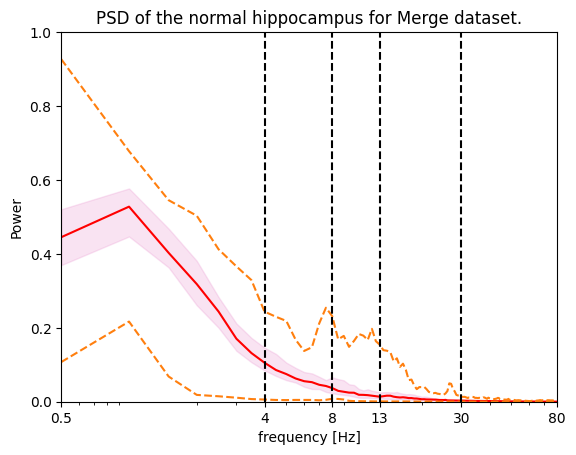

MNI


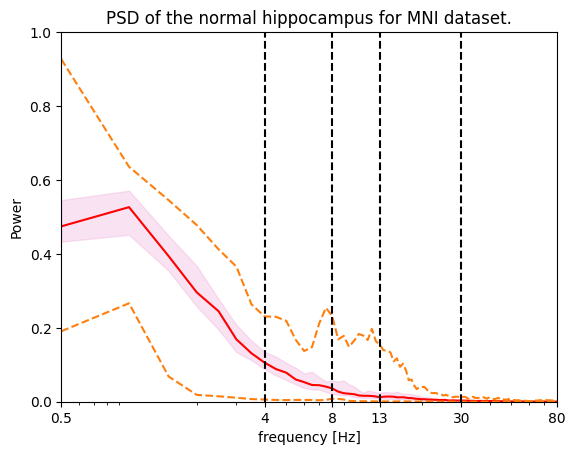

HUP


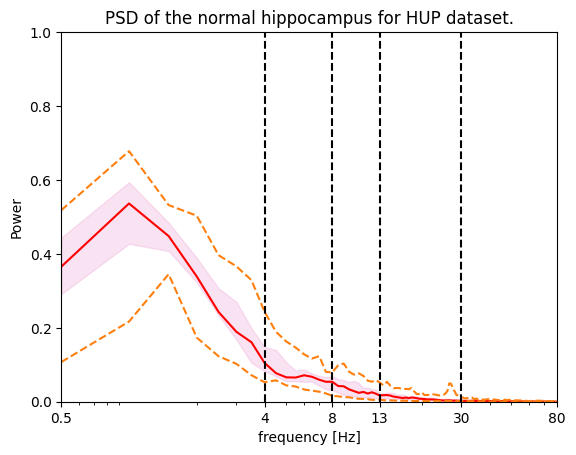

In [61]:
# Extract median, mean and std
median_dataset = {}
std_dataset = {}
mean_dataset = {}
for dataset in psd_per_dataset:
    # Extract data
    print(dataset)
    psd = psd_per_dataset[dataset]
    f = f_per_dataset[dataset]
    # # Plot and save the median curve
    # n_subj = len(np.unique(subj_per_region[region]))
    # n_chn = len(np.unique(chn_per_region[region]))
    median, mean, std = plotPaperFigures(f, psd, show_fig=True, title=f'PSD of the normal hippocampus for {dataset} dataset.')
    median_dataset[dataset] = median
    std_dataset[dataset] = std
    mean_dataset[dataset] = mean

### Get my data

In [50]:
# First run the code above (top of notebook) until the 7th cell: sub_sess_info[list(sub_sess_info.keys())[90]]
# Load snsx data
snsx_path = './snsx_data_collection.csv'
snsx_df = pd.read_csv(snsx_path, sep=',')
# Load mapping snsx to clinical
mapping = pd.read_csv('mapping_snsx_clinical.tsv', sep='\t')
mapping_dict = dict(zip(mapping['ieeg_subject'].to_list(), mapping['snsx_subject'].to_list()))
# Create new dict with data per labels
my_data_normal = []
my_subj_normal = []
my_chns_normal = []
for sub_sess in sub_sess_info:
    # Get bad hemispheres
    subj_clinical = sub_sess_info[sub_sess]['subject']
    subj_snsx = 'sub-' + mapping_dict[f"P{subj_clinical}"]
    # print(subj_snsx)
    bilobal, bad_R, bad_L = snsx_df[snsx_df['participant_id']==subj_snsx][['Bilobal', 'Right ', 'Left']].to_numpy().squeeze().astype(bool)
    # print(bad_R, bad_L)
    # Get labels of electrodes with main region
    chn_region = []
    for chn in sub_sess_info[sub_sess]['chn_info']:
        chn_info = sub_sess_info[sub_sess]['chn_info'][chn]
        chn_region.append((chn, list(chn_info.keys())[0]))
    # Get info from channels.tsv
    loc_df = pd.read_csv(sub_sess_info[sub_sess]['channels_tsv'], sep='\t')
    # Get info per edf file
    for edf_path in sub_sess_info[sub_sess]['edf_files']:
        edf = pyedflib.EdfReader(edf_path)
        # Get chn labels
        edf_chns = edf.getSignalLabels()
        for chn, region in chn_region:
            # Check if the channel is in a good hemi
            # Right hemi
            cond_R = (loc_df[loc_df['label']==chn]['x_init'].values[0] > 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] > 0) and not bad_R
            # Left hemi
            cond_L = (loc_df[loc_df['label']==chn]['x_init'].values[0] < 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] < 0) and not bad_L
            if not bilobal and (cond_R or cond_L):
                # print(cond_R, cond_L)
                # print(chn)
                data = edf.readSignal(edf_chns.index(chn))
                my_data_normal.append(data)
                my_subj_normal.append(subj_clinical)
                my_chns_normal.append(chn)
        edf.close()

In [51]:
my_data_normal = np.array(my_data_normal)
my_data_normal.shape

(281, 48000)

In [54]:
# Get psd
f_my_data_normal, psd_my_data_normal = welchMethod(my_data_normal, 200)

(281, 201)


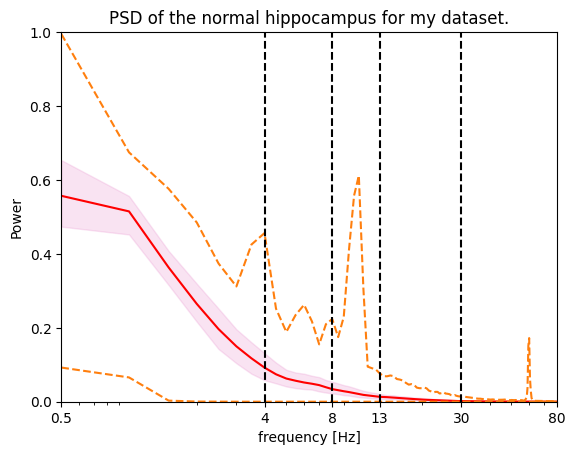

In [55]:
# Plot
median, mean, std = plotPaperFigures(f_my_data_normal, psd_my_data_normal, show_fig=True, title=f'PSD of the normal hippocampus for my dataset.')
median_my_data = median
std_my_data = std
mean_my_data = mean

### Plot comparisons

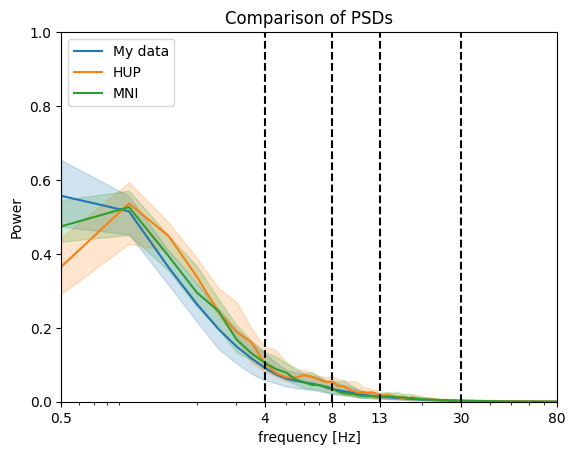

In [65]:
# PSD comparison
freq_list = [f_my_data_normal, f_per_dataset['HUP'], f_per_dataset['MNI']]
welchpow_list = [psd_my_data_normal, psd_per_dataset['HUP'], psd_per_dataset['MNI']]
dataset_names = ['My data', 'HUP', 'MNI']
plot_comparisons(freq_list, welchpow_list, dataset_names, show_fig=True, title='Comparison of PSDs')